    # Output CN plot

In [87]:
import matplotlib.pyplot as plt
import scgenome.plotting as pl
import anndata
import numpy as np
import copy
import os

In [88]:
base_path = "../../output/bahlis_10x"
data_base_path = '../../data/bahlis_10x/patient_MM-24.h5ad'
adata_raw = anndata.read_h5ad(data_base_path)

adata = copy.deepcopy(adata_raw)
chr_codes = {c: c[3:] for c in adata.var['chr'].unique()}
adata.var['chr'] = adata.var['chr'].map(chr_codes)

#### Examine HMMCopy clustering in anndata file (if exists)

In [89]:
hmmcopy_gmm_cluster_ids = adata.obs['cluster_id']
n_unique = hmmcopy_gmm_cluster_ids.values.unique()
cells_in_clusters = hmmcopy_gmm_cluster_ids.values.value_counts()
n_one_cell_clusters = (cells_in_clusters == 1).sum()
n_two_cell_clusters = (cells_in_clusters == 2).sum()
print(f"# one-cell clones {n_one_cell_clusters}")
print(f"# two-cell clones {n_two_cell_clusters}")
print(f"# three-to-five-cell clones {(cells_in_clusters <= 5).sum() - n_one_cell_clusters - n_two_cell_clusters}")
print(f"# larger clones {(cells_in_clusters > 5).sum()}")

# one-cell clones 21
# two-cell clones 3
# three-to-five-cell clones 7
# larger clones 9


#### Examine lower bound of GMM alg for model selection w.r.t. K

In [86]:
import sklearn
K_list = np.arange(10, 11)
elbo_list = []
hmm_states = adata.layers["state"]
for K in K_list:
    cluster_alg = sklearn.mixture.GaussianMixture(n_components=K, covariance_type="diag", n_init=10)
    cluster_alg.fit(hmm_states)
    labels = cluster_alg.predict(hmm_states)
    elbo_list.append(cluster_alg.lower_bound_)

KeyboardInterrupt: 

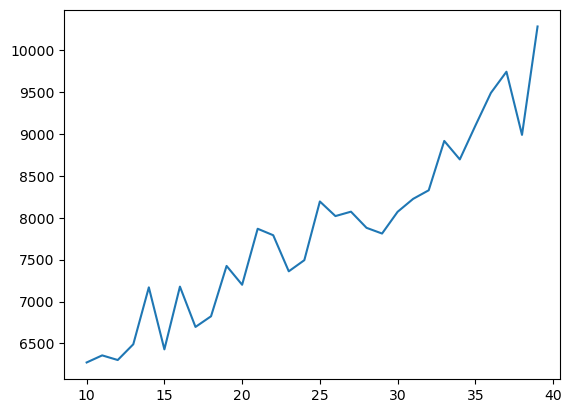

In [56]:
plt.plot(K_list, elbo_list)

#### Select a K and rerun clustering and make scgenome plot

In [91]:
selected_K = 20
cluster_alg = sklearn.mixture.GaussianMixture(n_components=selected_K, covariance_type="diag", n_init=10)
cluster_alg.fit(hmm_states)
labels = cluster_alg.predict(hmm_states)

adata.obs['gmm_cluster_id'] = labels

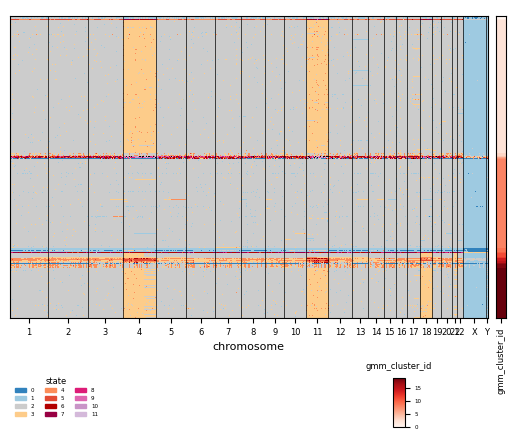

In [92]:
g = pl.plot_cell_cn_matrix_fig(adata, 'state', cell_order_fields=['gmm_cluster_id'], annotation_fields=['gmm_cluster_id'])

<Axes: xlabel='chromosome'>

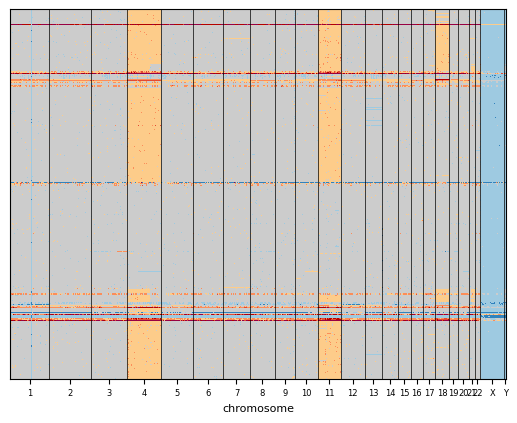

In [93]:
pl.plot_cell_cn_matrix(adata, 'state', cell_order_fields=['cluster_id'], max_cn=7)['ax']